## 知識情報学第5回演習サンプルプログラム ex5.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2017/11/02
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT Lisence

## ロジスティック回帰による手書き文字認識
- MNISTデータセットについては，詳しくは下記を参照
  - http://yann.lecun.com/exdb/mnist/
  - (注) httpsはアクセス不可．Chrome以外のブラウザを使用すること

In [5]:
%matplotlib inline
import os
import struct
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

### MNISTデータの読み込み関数

In [6]:
def load_mnist(path, kind='train'):

    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

### MNISTデータの読み込み

In [7]:
current_path = os.path.dirname(os.path.realpath('__file__'))
X_train, y_train = load_mnist(current_path, kind='train')
X_test, y_test = load_mnist(current_path, kind='t10k')

In [8]:
# 学習用に最初の1000点，テスト用に最初の1000点のデータを使用
# 動作が遅い場合は，学習データを小さくして下さい
X_train = X_train[:1000][:]
y_train = y_train[:1000][:]
X_test = X_test[:1000][:]
y_test = y_test[:1000][:]
print('#data: %d, #feature: %d (training data)' % (X_train.shape[0], X_train.shape[1]))
print('#data: %d, #feature: %d (test data)' % (X_test.shape[0], X_test.shape[1]))

#data: 1000, #feature: 784 (training data)
#data: 1000, #feature: 784 (test data)


### ロジスティック回帰のインスタンスの生成と学習
- 3クラス以上のマルチクラスへの対応は、multi_classで指定する。ovr(one-versus-rest)法は、1対多でクラス数分の識別器を構築し、テストデータのクラス分類は最も事後確率の高いクラスへ分類する方式。

In [9]:
lr = LogisticRegression(penalty='l2', C=1000.0, random_state=0, solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)

LogisticRegression(C=1000.0, multi_class='ovr', random_state=0,
                   solver='liblinear')

### 学習データおよびテストデータに対するaccuracyの算出

In [10]:
y_train_pred = lr.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0)*100 / X_train.shape[0]
print('accuracy for training data: %.2f%%' % acc)

y_test_pred = lr.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0)*100 / X_test.shape[0]
print('accuracy for test data: %.2f%%' % acc)

accuracy for training data: 100.00%
accuracy for test data: 81.70%


### 最初の25サンプルの識別結果をプロット
t: 正解クラス，p: 識別器による推測クラス

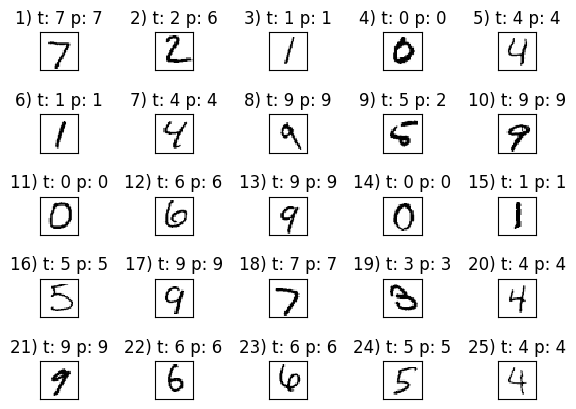

In [11]:
orign_img = X_test[:25]
true_lab = y_test[:25]
predicted_lab = y_test_pred[:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = orign_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, true_lab[i], predicted_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.subplots_adjust(hspace=1.0, wspace=2.0)
plt.show()

### パラメータを変化させてロジスティック回帰の挙動を観察する
- 【課題1a】逆正則化パラメータ（スライドのλの逆数）を10^-10から10^10まで10倍ずつ変化させたときの、非ゼロの重みの数とAccuracyをグラフにプロット
- 【課題2】引数penaltyを変更して，L1,L2正則化の効果を考察する．

In [12]:
n_nonzero_weights, params, accuracy_train, accuracy_test = [], [], [], []
for c in np.arange(-10, 11, dtype=float):
    # 逆正則化パラメータ
    param = 10**c
    
    # ロジスティック回帰のインスタンスを生成し，学習データに対して適合させる．
    lr = LogisticRegression(penalty='l2', C=param, random_state=0, solver='liblinear', multi_class='ovr')
    lr.fit(X_train, y_train)
    
    # 非ゼロの重みの数をn_nonzero_weightsに追加．one-vs-restのいずれかの一つのクラスに対応する重みのみで良い．
    # ヒント：学習済みの重みはcoef_[]に格納されている．また，非ゼロの要素数はnumpyのcount_nonzero()を使うと良い
    n_nonzero = np.count_nonzero(lr.coef_)
    n_nonzero_weights.append(n_nonzero)
    
    # 学習データおよびテストデータに対するAccuracyをaccuracy_train，accuracy_testに追加
    y_train_pred = lr.predict(X_train)
    acc = np.sum(y_train == y_train_pred, axis=0)*100 / X_train.shape[0]
    accuracy_train.append(acc)

    y_test_pred = lr.predict(X_test)
    acc = np.sum(y_test == y_test_pred, axis=0)*100 / X_test.shape[0]
    accuracy_test.append(acc)
    
    params.append(param)

### 分類精度のグラフ出力

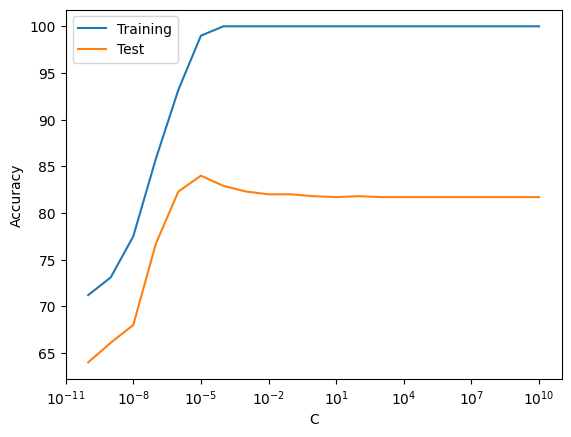

In [13]:
plt.plot(params, accuracy_train,label='Training')
plt.plot(params, accuracy_test, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()
#下記は実行例

### 非ゼロ重みの数のグラフ出力

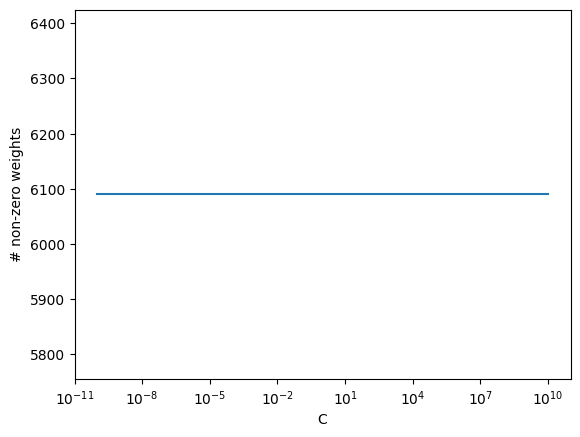

In [14]:
plt.plot(params, n_nonzero_weights)
plt.ylabel('# non-zero weights')
plt.xlabel('C')
plt.xscale('log')
plt.show()
#下記は実行例

### 【課題1b】学習済み重みの2次元プロット
- いずれかひとつのクラスのみで良い

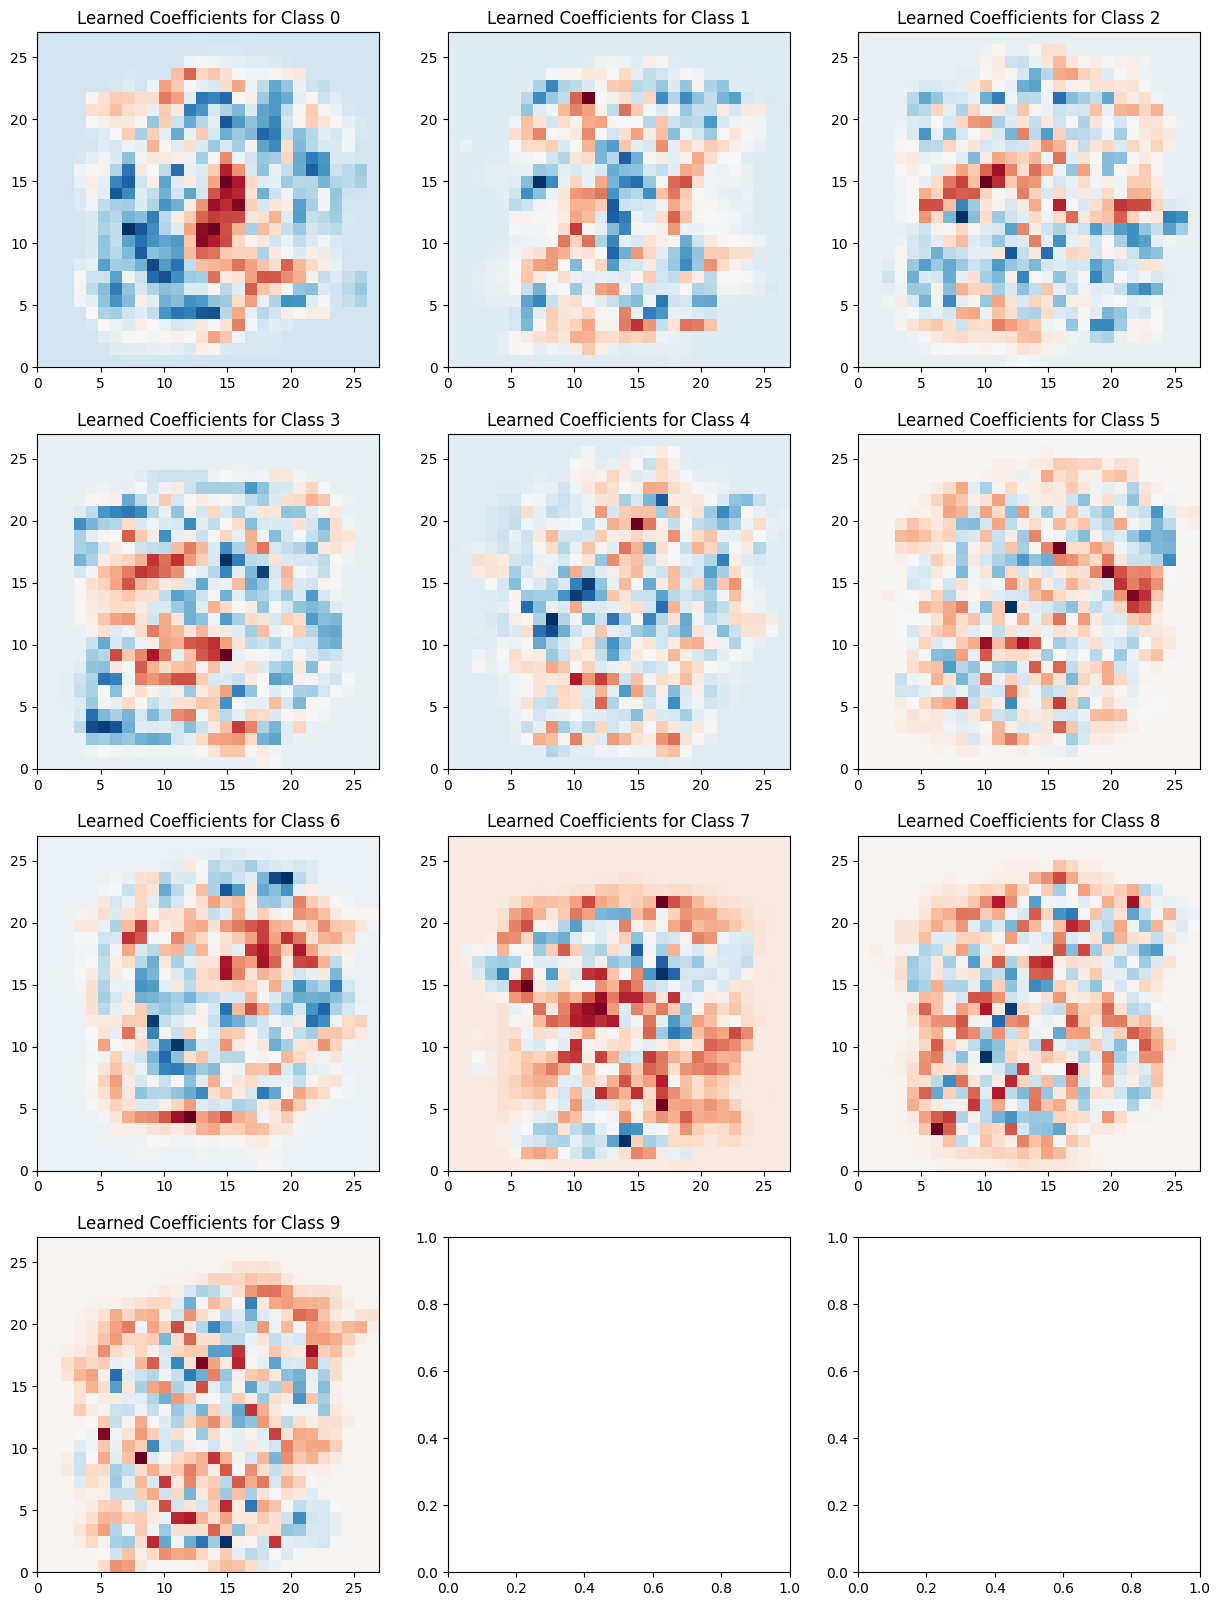

In [27]:
lr = LogisticRegression(penalty='l2', C=1000.0, random_state=0, solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)

num_columns = 3
num_rows = 4
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
for class_index in range(10):
    coefficients = lr.coef_[class_index]

    coeff_image = coefficients.reshape(28, 28)

    # Create an image plot of the coefficients
    ax = axes[(class_index) // num_columns, (class_index) % num_columns]
    ax.imshow(coeff_image, cmap=plt.cm.RdBu, aspect='auto', extent=[0, 27, 0, 27])
    ax.set_title(f'Learned Coefficients for Class {class_index}')


plt.show()

## 課題5-2. L1, L2正則化の効果の違いを非ゼロの重みの数とaccuracyの観点で考察しなさい．

In [29]:
l1_n_nonzero_weights, l1_params, l1_accuracy_train, l1_accuracy_test = [], [], [], []
for c in np.arange(-10, 11, dtype=float):
    # 逆正則化パラメータ
    param = 10**c
    
    # ロジスティック回帰のインスタンスを生成し，学習データに対して適合させる．
    lr = LogisticRegression(penalty='l1', C=param, random_state=0, solver='liblinear', multi_class='ovr')
    lr.fit(X_train, y_train)
    
    # 非ゼロの重みの数をn_nonzero_weightsに追加．one-vs-restのいずれかの一つのクラスに対応する重みのみで良い．
    # ヒント：学習済みの重みはcoef_[]に格納されている．また，非ゼロの要素数はnumpyのcount_nonzero()を使うと良い
    n_nonzero = np.count_nonzero(lr.coef_)
    l1_n_nonzero_weights.append(n_nonzero)
    
    # 学習データおよびテストデータに対するAccuracyをaccuracy_train，accuracy_testに追加
    y_train_pred = lr.predict(X_train)
    acc = np.sum(y_train == y_train_pred, axis=0)*100 / X_train.shape[0]
    l1_accuracy_train.append(acc)

    y_test_pred = lr.predict(X_test)
    acc = np.sum(y_test == y_test_pred, axis=0)*100 / X_test.shape[0]
    l1_accuracy_test.append(acc)
    
    l1_params.append(param)

In [32]:
l2_n_nonzero_weights, l2_params, l2_accuracy_train, l2_accuracy_test = [], [], [], []
for c in np.arange(-10, 11, dtype=float):
    # 逆正則化パラメータ
    param = 10**c
    
    # ロジスティック回帰のインスタンスを生成し，学習データに対して適合させる．
    lr = LogisticRegression(penalty='l2', C=param, random_state=0, solver='liblinear', multi_class='ovr')
    lr.fit(X_train, y_train)
    
    # 非ゼロの重みの数をn_nonzero_weightsに追加．one-vs-restのいずれかの一つのクラスに対応する重みのみで良い．
    # ヒント：学習済みの重みはcoef_[]に格納されている．また，非ゼロの要素数はnumpyのcount_nonzero()を使うと良い
    n_nonzero = np.count_nonzero(lr.coef_)
    l2_n_nonzero_weights.append(n_nonzero)
    
    # 学習データおよびテストデータに対するAccuracyをaccuracy_train，accuracy_testに追加
    y_train_pred = lr.predict(X_train)
    acc = np.sum(y_train == y_train_pred, axis=0)*100 / X_train.shape[0]
    l2_accuracy_train.append(acc)

    y_test_pred = lr.predict(X_test)
    acc = np.sum(y_test == y_test_pred, axis=0)*100 / X_test.shape[0]
    l2_accuracy_test.append(acc)
    
    l2_params.append(param)

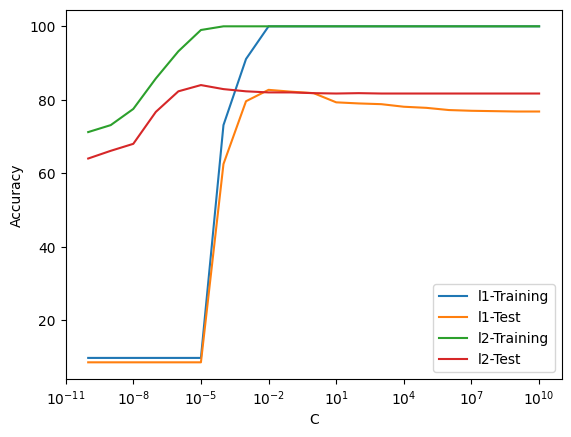

In [34]:
plt.plot(l1_params, l1_accuracy_train,label='l1-Training')
plt.plot(l1_params, l1_accuracy_test, label='l1-Test')
plt.plot(l2_params, l2_accuracy_train,label='l2-Training')
plt.plot(l2_params, l2_accuracy_test, label='l2-Test')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend(loc='lower right')
plt.xscale('log')
plt.show()

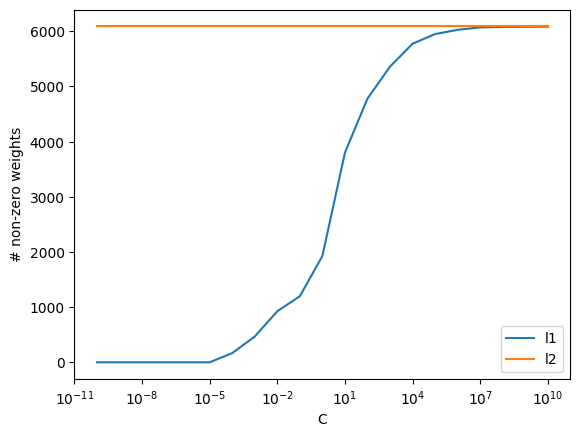

In [36]:
plt.plot(l1_params, l1_n_nonzero_weights,label='l1')
plt.plot(l2_params, l2_n_nonzero_weights,label='l2')
plt.ylabel('# non-zero weights')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

L1正則化は、重要な特徴量を選択して他の特徴量の重みをゼロに近づける傾向があるため、非ゼロの重みの数がL2正則化と比較し、少なくなっている。\
今回用いたデータセットでは、特徴量が多く、重要な特徴量が他の特徴量と混在しているため、特徴量の選択を行わないL2正則化のほうがAccuracyが高くなったと考えられる。